In [92]:
import os
import matplotlib.pyplot as plt
import math

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import datetime

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores

from feature_eng.format_df import merge_sofifa_fbref_results, format_sofifa_fbref_data, add_signals


In [2]:

load_dotenv("./../../secrets.env")
DB_USER = 'kube'
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = 'localhost'
DB_PORT = 8110
DB_NAME = 'optimsportbets-db'

DB_TN_FBREF_RESULTS = 'fbref_results'
DB_TN_ODDS = 'soccer_odds'
DB_TN_SOFIFA_TEAMS_STATS = 'sofifa_teams_stats'
DB_TN_MODELS_RESULTS = 'models_results'
DB_TN_OPTIM_RESULTS = 'optim_results'

In [4]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_FBREF_RESULTS}")
    fbref_results_df = pd.read_sql(query, connection)
    sofifa_teams_stats_df = pd.read_sql(f'SELECT * FROM {DB_TN_SOFIFA_TEAMS_STATS}', connection)

In [5]:
date_stop = datetime.datetime.now()
fbref_results_df__sofifa_merged = merge_sofifa_fbref_results(fbref_results_df, sofifa_teams_stats_df)
fbref_results_df__sofifa_merged__data_formated = format_sofifa_fbref_data(fbref_results_df__sofifa_merged, date_stop=date_stop)
fbref_results_df__sofifa_merged__data_formated__signals_added = add_signals(fbref_results_df__sofifa_merged__data_formated, date_stop=date_stop)

rule_is_before_datetime = fbref_results_df__sofifa_merged__data_formated__signals_added["datetime"] < date_stop
fbref_results_df__sofifa_merged__data_formated__signals_added__train = fbref_results_df__sofifa_merged__data_formated__signals_added[rule_is_before_datetime]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added[~rule_is_before_datetime]

In [94]:
X_col_sofifa =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = [
    'elo_home_before', 'elo_away_before',
    'home_team_number_of_match_played', 'away_team_number_of_match_played',
    'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
    'glicko2_rd_away_before', 'glicko2_vol_home_before',
    'glicko2_vol_away_before', 'trueskill_home_before',
    'trueskill_away_before', 'home_team_goals_season_to_date_before_match',
'away_team_goals_season_to_date_before_match',
'avg_home_team_goals_season_to_date_before_match',
'avg_away_team_goals_season_to_date_before_match']

X_cat = ['home_league',
 'home_build_up_speed',
 'home_build_up_dribbling',
 'home_build_up_passing',
 'home_build_up_positioning',
 'home_chance_creation_crossing',
 'home_chance_creation_passing',
 'home_chance_creation_shooting',
 'home_chance_creation_positioning',
 'home_defence_aggression',
 'home_defence_pressure',
 'home_defence_team_width',
 'home_defence_defender_line',
 'away_league',
 'away_build_up_speed',
 'away_build_up_dribbling',
 'away_build_up_passing',
 'away_build_up_positioning',
 'away_chance_creation_crossing',
 'away_chance_creation_passing',
 'away_chance_creation_shooting',
 'away_chance_creation_positioning',
 'away_defence_aggression',
 'away_defence_pressure',
 'away_defence_team_width',
 'away_defence_defender_line',]


Y_col = 'FTR'

X_col = X_col_sofifa + X_col_scores

# All features
df_cat_onehot = pd.get_dummies(fbref_results_df__sofifa_merged__data_formated__signals_added__train[X_cat], drop_first=True)
X_col = X_col + df_cat_onehot.columns.tolist()
df_all = pd.concat([fbref_results_df__sofifa_merged__data_formated__signals_added__train, df_cat_onehot], axis=1)

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

In [36]:
df_all[X_col].describe()

,home_overall,home_attack,home_midfield,home_defence,home_transfer_budget,home_club_worth,home_defence_domestic_prestige,home_international_prestige,home_players,home_starting_xi_average_age,...,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before,home_team_goals_season_to_date_before_match,away_team_goals_season_to_date_before_match,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match
count,28849.000000,28849.000000,28849.000000,28849.000000,2.884900e+04,2.884900e+04,28849.000000,28849.000000,28849.000000,28849.000000,...,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000,28849.000000
mean,76.168602,75.923048,75.076328,74.553988,7.083958e+05,2.049160e+09,9.161877,8.278866,30.339561,26.358090,...,30.463199,30.549059,0.059790,0.059790,21.845524,21.849012,22.983431,23.138826,1.304725,1.321725
std,3.767297,4.861223,4.492236,4.264116,1.859955e+06,7.709715e+09,5.237973,5.649022,2.946002,1.457773,...,21.043389,21.557595,0.000158,0.000158,3.423310,3.460151,17.244458,17.272803,0.619888,0.633090
min,67.000000,63.000000,60.000000,61.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,21.000000,21.640000,...,25.273042,25.246519,0.059350,0.059348,-1.924307,-1.893852,0.000000,0.000000,0.000000,0.000000
25%,73.000000,73.000000,72.000000,72.000000,4.000000e+04,0.000000e+00,5.000000,3.000000,28.000000,25.360000,...,28.385875,28.385413,0.059674,0.059674,20.883015,20.898060,9.000000,9.000000,0.964286,1.000000
50%,76.000000,76.000000,75.000000,74.000000,1.900000e+05,3.200000e+05,9.000000,7.000000,31.000000,26.360000,...,28.724902,28.721012,0.059820,0.059820,22.024825,22.030498,21.000000,21.000000,1.233333,1.250000
75%,79.000000,79.000000,78.000000,77.000000,6.000000e+05,4.580000e+06,13.000000,13.000000,33.000000,27.360000,...,28.947295,28.945545,0.059926,0.059926,23.610368,23.622910,33.000000,33.000000,1.615385,1.631579
max,87.000000,93.000000,89.000000,87.000000,1.909000e+07,4.800000e+10,20.000000,20.000000,40.000000,31.820000,...,350.000000,350.000000,0.060003,0.060003,28.613303,28.583072,109.000000,107.000000,7.000000,8.000000


In [38]:
train_test_split_fn_exp = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
train_test_split_fn_slid = lambda df : train_test_split_sliding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1
metrics_mean, metrics, _ = train_test(df_all,
                                       pipeline, X_col, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
train_test_metrics


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,metrics,values
0,accuracy,0.522813
1,weighted_accuracy,0.668826
2,accuracy_home,0.605771
3,accuracy_draw,0.731650
4,accuracy_away,0.708206
5,macro_avg_recall,0.454006
6,micro_avg_recall,0.522813
7,weighted_recall,0.522813
8,recall_home,0.821773
9,recall_draw,0.008715


In [40]:
metrics_mean, metrics, _ = train_test(df_all, pipeline, X_col, Y_col, train_test_split_fn_slid, result_df_all_splits, m, beta)
train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
train_test_metrics

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,metrics,values
0,accuracy,0.519206
1,weighted_accuracy,0.667058
2,accuracy_home,0.608296
3,accuracy_draw,0.725699
4,accuracy_away,0.704418
5,macro_avg_recall,0.452496
6,micro_avg_recall,0.519206
7,weighted_recall,0.519206
8,recall_home,0.810343
9,recall_draw,0.030505


In [44]:
# Récupérer le modèle (LogisticRegression) à partir du pipeline
model = pipeline.named_steps['model']

# Récupérer les coefficients de la régression logistique
coefficients = model.coef_[0]  # Coefficients pour chaque feature

# Associer les coefficients avec les noms des features
feature_importance = pd.DataFrame({
    'Feature': X_col,
    'Importance': coefficients
})

# Trier par importance absolue
feature_importance['Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
feature_importance.head(20)

,Feature,Importance
25,away_team_number_of_match_played,0.227557
24,home_team_number_of_match_played,0.221361
22,elo_home_before,0.213429
27,glicko2_away_before,0.198486
26,glicko2_home_before,0.171494
23,elo_away_before,0.148150
72,away_build_up_dribbling_Normal,0.136813
46,home_build_up_dribbling_Normal,0.135611
61,home_defence_team_width_Normal,0.134419
0,home_overall,0.116250


In [9]:

pipeline.fit(fbref_results_df__sofifa_merged__data_formated__signals_added__train[X_col], fbref_results_df__sofifa_merged__data_formated__signals_added__train[Y_col])
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added__infer.copy()
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'pred'] = pipeline.predict(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_home_win'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 2]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_draw'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 1]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_away_win'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 0]


In [49]:
selected_features = []
metrics_by_step = []
metric_of_importance = 'mse'
worst_metric = np.inf

# Liste des features disponibles
available_features = X_col
#available_features = ['elo_home_before', 'elo_away_before']

# Feature selection avec log loss
for i in range(len(available_features)):
    # Pour chaque itération, on ajoute une nouvelle feature à la liste des features sélectionnées
    best_metric_of_importance = worst_metric
    best_feature = None
    
    for feature in available_features:
        # Créer une liste des features actuelles
        current_features = selected_features + [feature]
        
        # Entraîner le pipeline sur le sous-ensemble de features
        metrics_mean, metrics, _ = train_test(df_all, 
                                              pipeline, current_features, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
        
        # Calculer la log loss
        current_metric_of_importance = metrics_mean[metric_of_importance]
        
        # Si la log loss s'améliore, on garde cette feature comme la meilleure pour cette itération
        if current_metric_of_importance < best_metric_of_importance:
            best_metric_of_importance = current_metric_of_importance
            best_feature = feature
    
    # Ajouter la meilleure feature trouvée
    selected_features.append(best_feature)
    available_features.remove(best_feature)
    
    # Stocker la log loss pour cette itération
    metrics_by_step.append(metrics_mean.copy())

    # Afficher la progression
    print(f"Feature ajoutée : {best_feature}, {metric_of_importance} : {best_metric_of_importance}")

# Résultats finaux sous forme de DataFrame
feature_selection_results = pd.DataFrame({
    'Selected_Features': selected_features,
    **{metric : [metric_by_step[metric] for metric_by_step in metrics_by_step] for metric in metrics_by_step[0].keys()}
})

# Afficher le résultat final
print(feature_selection_results)

Feature ajoutée : elo_away_before, mse : 0.20612555610390423
Feature ajoutée : elo_home_before, mse : 0.19661070295967153
Feature ajoutée : glicko2_vol_away_before, mse : 0.19619150990950487
Feature ajoutée : away_overall, mse : 0.19594315580978244
Feature ajoutée : home_overall, mse : 0.1953965039643589
Feature ajoutée : away_build_up_speed_Slow, mse : 0.1951780094209184
Feature ajoutée : away_starting_xi_average_age, mse : 0.19501265871513498
Feature ajoutée : home_league_INT, mse : 0.19486832532673606
Feature ajoutée : avg_home_team_goals_season_to_date_before_match, mse : 0.1947562194484167
Feature ajoutée : home_build_up_positioning_Organised, mse : 0.194665655550894
Feature ajoutée : home_build_up_speed_Fast, mse : 0.19460651070834642
Feature ajoutée : away_defence_pressure_High, mse : 0.1945676131176778
Feature ajoutée : away_defence_defender_line_Offside trap, mse : 0.19453312004413628
Feature ajoutée : home_league_ITA-Serie A, mse : 0.19449183865861522
Feature ajoutée : glicko

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Feature ajoutée : home_league_FRA-Ligue 1, mse : 0.19634597397373524
Feature ajoutée : away_league_FRA-Ligue 1, mse : 0.1963419905875664
Feature ajoutée : home_league_GER-Bundesliga, mse : 0.19645978409232215


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature ajoutée : away_league_GER-Bundesliga, mse : 0.19646456085597014
              Selected_Features  accuracy  weighted_accuracy  accuracy_home  \
0               elo_away_before  0.436429           0.594186       0.436429   
1               elo_home_before  0.495221           0.646794       0.564292   
2       glicko2_vol_away_before  0.515059           0.661971       0.586835   
3                  away_overall  0.514698           0.662900       0.595672   
4                  home_overall  0.520108           0.666644       0.599639   
..                          ...       ...                ...            ...   
85  home_international_prestige  0.520830           0.668498       0.609378   
86      home_league_FRA-Ligue 1  0.522092           0.667990       0.602885   
87      away_league_FRA-Ligue 1  0.523354           0.669214       0.606312   
88   home_league_GER-Bundesliga  0.523354           0.669192       0.606312   
89   away_league_GER-Bundesliga  0.522633           0.66869

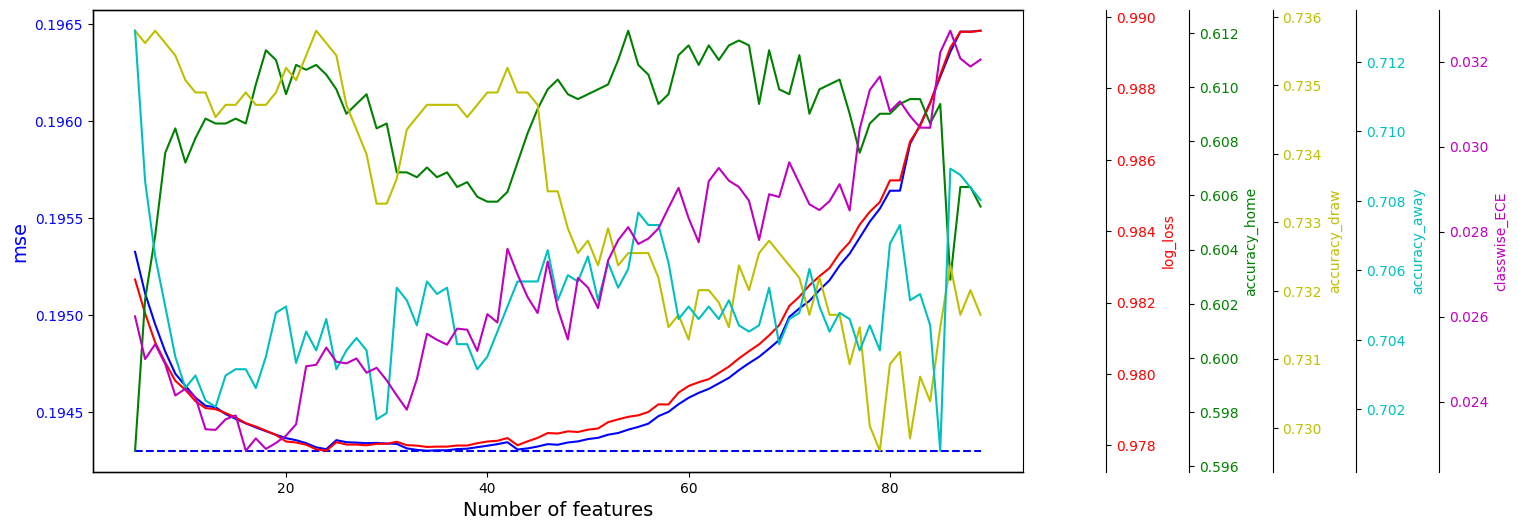

In [191]:
import matplotlib.pyplot as plt

start_idx = 5
stop_idx = 90
OUTWARD_SHIFT_SCALE = 60
outward_shift = 0

#metrics_to_show = ['mse', 'log_loss', "macro_avg_f_mesure", "micro_avg_f_mesure", "weighted_f_mesure", 'classwise_ECE', 'mse_home', 'mse_draw', 'mse_away']
metrics_to_show = ['mse', 'log_loss', "accuracy_home", "accuracy_draw", "accuracy_away", 'classwise_ECE']
#metrics_to_show =  ['mse', "accuracy_home", "accuracy_draw", "accuracy_away"]
colors = ['b', 'r', 'g', 'y', 'c', 'm', 'k', 'c', 'm', 'k']*2
fig, ax1 = plt.subplots(figsize=(12, 6))

# Premier axe Y 
ax1.plot(range(start_idx, stop_idx), feature_selection_results[metrics_to_show[0]][start_idx:stop_idx], color='b', label=metrics_to_show[0])
ax1.plot(range(start_idx, stop_idx), [np.min(feature_selection_results[metrics_to_show[0]][start_idx:stop_idx])]*len(range(start_idx, stop_idx)), color='b', linestyle='--', label=f'Min {metrics_to_show[0]}')
ax1.set_xlabel('Number of features', fontdict={'fontsize': 14})
ax1.set_ylabel(metrics_to_show[0], color='b', fontdict={'fontsize': 14})
ax1.tick_params(axis='y', labelcolor='b')

for metric in metrics_to_show[1:]:
    ax = ax1.twinx()
    outward_shift += OUTWARD_SHIFT_SCALE
    ax.spines['right'].set_position(('outward', outward_shift))
    ax.plot(range(start_idx, stop_idx), feature_selection_results[metric][start_idx:stop_idx], label=metric, color=colors[metrics_to_show.index(metric)])
    ax.set_ylabel(metric, color=colors[metrics_to_show.index(metric)])
    ax.tick_params(axis='y', labelcolor=colors[metrics_to_show.index(metric)])


# Titre du graphique
#plt.title(f'Evolution of the metrics in function of the number of features')

plt.show()


In [90]:
feature_selection_results.head(40)

,Selected_Features,accuracy,weighted_accuracy,accuracy_home,accuracy_draw,accuracy_away,macro_avg_recall,micro_avg_recall,weighted_recall,recall_home,...,loss_draw,loss_away,mse,mse_home,mse_draw,mse_away,classwise_ECE,ECE_home,ECE_draw,ECE_away
0,elo_away_before,0.436429,0.594186,0.436429,0.735978,0.700451,0.333333,0.436429,0.436429,1.000000,...,0.358659,0.376227,0.216780,0.246242,0.194341,0.209757,0.017354,0.022240,0.011494,0.018327
1,elo_home_before,0.495221,0.646794,0.564292,0.735978,0.690171,0.423363,0.495221,0.495221,0.824908,...,0.359647,0.322852,0.206092,0.231599,0.194120,0.192558,0.023569,0.025898,0.012917,0.031893
2,glicko2_vol_away_before,0.515059,0.661971,0.586835,0.735978,0.707304,0.444233,0.515059,0.515059,0.838398,...,0.363159,0.324290,0.196527,0.215104,0.192303,0.182174,0.027861,0.034308,0.019042,0.030235
3,away_overall,0.514698,0.662900,0.595672,0.735798,0.697926,0.446853,0.514698,0.514698,0.816750,...,0.355246,0.316269,0.196141,0.214399,0.192201,0.181822,0.024428,0.025859,0.019160,0.028266
4,home_overall,0.520108,0.666644,0.599639,0.736159,0.704418,0.451855,0.520108,0.520108,0.824074,...,0.355224,0.317717,0.195897,0.214173,0.192208,0.181310,0.028565,0.032835,0.023316,0.029544
5,away_build_up_speed_Slow,0.522633,0.667767,0.596573,0.735798,0.712894,0.452342,0.522633,0.522633,0.838654,...,0.356727,0.322046,0.195326,0.213231,0.192053,0.180694,0.026003,0.028270,0.021360,0.028380
6,away_starting_xi_average_age,0.523174,0.668619,0.602164,0.735618,0.708566,0.453562,0.523174,0.523174,0.829986,...,0.355600,0.315863,0.195112,0.212853,0.192018,0.180464,0.024999,0.025523,0.020898,0.028576
7,home_league_INT,0.523354,0.668985,0.604509,0.735798,0.706402,0.454227,0.523354,0.523354,0.827919,...,0.355522,0.314943,0.194952,0.212847,0.191906,0.180103,0.025350,0.027782,0.023165,0.025102
8,avg_home_team_goals_season_to_date_before_match,0.524076,0.669744,0.607574,0.735618,0.704959,0.455648,0.524076,0.524076,0.821189,...,0.355990,0.311096,0.194812,0.212581,0.191898,0.179957,0.024879,0.024795,0.023652,0.026191
9,home_build_up_positioning_Organised,0.523715,0.669637,0.608476,0.735437,0.703517,0.455485,0.523715,0.523715,0.819517,...,0.355543,0.310804,0.194698,0.212347,0.191729,0.180019,0.024142,0.023524,0.022783,0.026120


In [91]:
feature_selection_results.tail(20)

,Selected_Features,accuracy,weighted_accuracy,accuracy_home,accuracy_draw,accuracy_away,macro_avg_recall,micro_avg_recall,weighted_recall,recall_home,...,loss_draw,loss_away,mse,mse_home,mse_draw,mse_away,classwise_ECE,ECE_home,ECE_draw,ECE_away
70,glicko2_vol_home_before,0.523354,0.669861,0.609739,0.732372,0.704599,0.456347,0.523354,0.523354,0.813880,...,0.361819,0.310194,0.194990,0.212255,0.192071,0.180645,0.029630,0.032092,0.026702,0.030095
71,glicko2_away_before,0.524076,0.670479,0.611181,0.732191,0.704779,0.457115,0.524076,0.524076,0.814211,...,0.362029,0.310167,0.195034,0.212277,0.192131,0.180696,0.029138,0.027755,0.029318,0.030340
72,avg_away_team_goals_season_to_date_before_match,0.523354,0.669783,0.609017,0.731650,0.706041,0.456302,0.523354,0.523354,0.816065,...,0.361859,0.310802,0.195073,0.212257,0.192201,0.180760,0.028641,0.028357,0.028746,0.028821
73,home_build_up_passing_Mixed,0.523535,0.670034,0.609919,0.732191,0.704959,0.456749,0.523535,0.523535,0.815265,...,0.362102,0.310708,0.195129,0.212347,0.192255,0.180786,0.028506,0.027876,0.028897,0.028746
74,home_transfer_budget,0.522994,0.669777,0.610099,0.731650,0.704238,0.455932,0.522994,0.522994,0.816071,...,0.362015,0.310960,0.195179,0.212413,0.192251,0.180874,0.028714,0.028446,0.029138,0.028559
75,home_chance_creation_positioning_Organised,0.523354,0.670019,0.610280,0.731650,0.704779,0.456359,0.523354,0.523354,0.815710,...,0.361794,0.311149,0.195255,0.212522,0.192258,0.180985,0.029115,0.029557,0.028262,0.029526
76,home_midfield,0.522272,0.669184,0.609017,0.730929,0.704599,0.454977,0.522272,0.522272,0.816087,...,0.361981,0.311743,0.195317,0.212645,0.192238,0.181067,0.028496,0.029774,0.025840,0.029874
77,home_defence_team_width_Normal,0.521371,0.668454,0.607574,0.731470,0.703697,0.454258,0.521371,0.521371,0.813510,...,0.361987,0.312231,0.195399,0.212663,0.192305,0.181228,0.030414,0.030752,0.028930,0.031559
78,home_defence_pressure_High,0.521551,0.668724,0.608656,0.730027,0.704418,0.454224,0.521551,0.521551,0.814717,...,0.362373,0.312124,0.195481,0.212841,0.192335,0.181267,0.031331,0.030815,0.030453,0.032725
79,home_league_ESP-La Liga,0.521190,0.668579,0.609017,0.729666,0.703697,0.453933,0.521190,0.521190,0.814350,...,0.362639,0.312755,0.195548,0.212983,0.192378,0.181283,0.031648,0.030543,0.032477,0.031923


In [51]:
# Exporter en CSV
feature_selection_results.to_csv('feature_selection_results_mse.csv', index=False)


# Randomforest froward selection

In [95]:
selected_features_rf = []
metrics_by_step_rf = []
metric_of_importance = 'mse'
worst_metric = np.inf
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier())
    ])

# Liste des features disponibles
available_features = X_col.copy()
#available_features = ['elo_home_before', 'elo_away_before']

# Feature selection avec log loss
for i in range(len(available_features)):
    # Pour chaque itération, on ajoute une nouvelle feature à la liste des features sélectionnées
    best_metric_of_importance = worst_metric
    best_feature = None
    
    for feature in available_features:
        # Créer une liste des features actuelles
        current_features = selected_features + [feature]
        
        # Entraîner le pipeline sur le sous-ensemble de features
        metrics_mean, metrics, _ = train_test(df_all, 
                                              pipeline, current_features, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
        
        # Calculer la log loss
        current_metric_of_importance = metrics_mean[metric_of_importance]
        
        # Si la log loss s'améliore, on garde cette feature comme la meilleure pour cette itération
        if current_metric_of_importance < best_metric_of_importance:
            best_metric_of_importance = current_metric_of_importance
            best_feature = feature
    
    # Ajouter la meilleure feature trouvée
    selected_features_rf.append(best_feature)
    available_features.remove(best_feature)
    
    # Stocker la log loss pour cette itération
    metrics_by_step_rf.append(metrics_mean.copy())

    # Afficher la progression
    print(f"Feature ajoutée : {best_feature}, {metric_of_importance} : {best_metric_of_importance}")

# Résultats finaux sous forme de DataFrame
feature_selection_results_rf = pd.DataFrame({
    'Selected_Features': selected_features_rf,
    **{metric : [metric_by_step[metric] for metric_by_step in metrics_by_step_rf] for metric in metrics_by_step_rf[0].keys()}
})

# Afficher le résultat final
print(feature_selection_results_rf)

Feature ajoutée : away_overall, mse : 0.2082258398260377
Feature ajoutée : home_overall, mse : 0.20904819202706112
Feature ajoutée : away_defence, mse : 0.20922437470531205
Feature ajoutée : away_midfield, mse : 0.20924370977948836
Feature ajoutée : away_attack, mse : 0.2096522668135794
Feature ajoutée : home_midfield, mse : 0.21068916936375448
Feature ajoutée : home_defence, mse : 0.21089869014175475
Feature ajoutée : home_attack, mse : 0.2112675578606511
Feature ajoutée : home_international_prestige, mse : 0.21133764949714134
Feature ajoutée : home_defence_domestic_prestige, mse : 0.2116799814693863
Feature ajoutée : away_defence_domestic_prestige, mse : 0.21205694938837163
Feature ajoutée : away_international_prestige, mse : 0.21300501890366866
Feature ajoutée : away_team_goals_season_to_date_before_match, mse : 0.21448807404401543
Feature ajoutée : home_team_goals_season_to_date_before_match, mse : 0.2153064416484379


KeyboardInterrupt: 

In [16]:
selected_features = []
accuracys = []

# Liste des features disponibles
available_features = X_col

# Feature selection avec log loss
for i in range(len(available_features)):
    # Pour chaque itération, on ajoute une nouvelle feature à la liste des features sélectionnées
    best_accuracy = 0
    best_feature = None
    
    for feature in available_features:
        # Créer une liste des features actuelles
        current_features = selected_features + [feature]
        
        # Entraîner le pipeline sur le sous-ensemble de features
        metrics_mean, metrics, _ = train_test(fbref_results_df__sofifa_merged__data_formated__signals_added__train, 
                                              pipeline, current_features, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
        
        # Calculer la log loss
        current_accuracy = metrics_mean["accuracy"]
        
        # Si la log loss s'améliore, on garde cette feature comme la meilleure pour cette itération
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_feature = feature
    
    # Ajouter la meilleure feature trouvée
    selected_features.append(best_feature)
    available_features.remove(best_feature)
    
    # Stocker la log loss pour cette itération
    accuracys.append(best_accuracy)

    # Afficher la progression
    print(f"Feature ajoutée : {best_feature}, accuracy : {best_accuracy}")

# Résultats finaux sous forme de DataFrame
feature_selection_results = pd.DataFrame({
    'Selected_Features': selected_features,
    'accuracy': accuracys
})

# Afficher le résultat final
print(feature_selection_results)

Feature ajoutée : glicko2_away_before, accuracy : 0.4964833183047791
Feature ajoutée : glicko2_home_before, accuracy : 0.5165013525698827
Feature ajoutée : home_transfer_budget, accuracy : 0.5179440937781785
Feature ajoutée : away_attack, accuracy : 0.5186654643823264
Feature ajoutée : home_midfield, accuracy : 0.5202885482416593
Feature ajoutée : away_midfield, accuracy : 0.5231740306582507
Feature ajoutée : home_starting_xi_average_age, accuracy : 0.5240757439134356
Feature ajoutée : glicko2_rd_home_before, accuracy : 0.5246167718665464
Feature ajoutée : away_transfer_budget, accuracy : 0.5249774571686203
Feature ajoutée : home_whole_team_average_age, accuracy : 0.5247971145175835
Feature ajoutée : glicko2_rd_away_before, accuracy : 0.5249774571686203
Feature ajoutée : away_players, accuracy : 0.5249774571686203
Feature ajoutée : trueskill_away_before, accuracy : 0.5249774571686203
Feature ajoutée : away_defence_domestic_prestige, accuracy : 0.5247971145175834
Feature ajoutée : home_

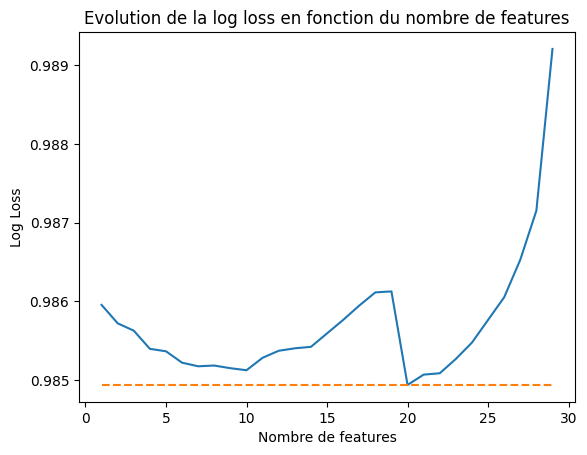

In [22]:
start_idx = 5
plt.plot(range(1, len(log_losses[start_idx:]) + 1), log_losses[start_idx:])
plt.plot(range(1, len(log_losses[start_idx:]) + 1), [min(log_losses[start_idx:])] * len(log_losses[start_idx:]), linestyle='--')
plt.xlabel('Nombre de features')
plt.ylabel('Log Loss')
plt.title('Evolution de la log loss en fonction du nombre de features')
plt.show()

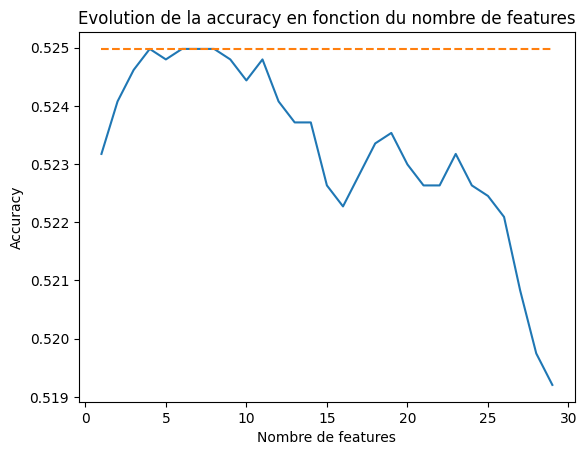

In [24]:
start_idx = 5
plt.plot(range(1, len(accuracys[start_idx:]) + 1), accuracys[start_idx:])
plt.plot(range(1, len(accuracys[start_idx:]) + 1), [max(accuracys[start_idx:])] * len(accuracys[start_idx:]), linestyle='--')
plt.xlabel('Nombre de features')
plt.ylabel('Accuracy')
plt.title('Evolution de la accuracy en fonction du nombre de features')
plt.show()

In [28]:
fbref_results_df__sofifa_merged__data_formated__signals_added__train.sort_values(by='date', ascending=False,)

,game_id,league,season,game,round,week,day,date,time,home_team,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
32027,d701a1df,ENG-Premier League,2425,2024-09-22 Brighton-Nott'ham Forest,None,5.0,Sun,2024-09-22,14:00:00,Brighton,...,2.000000,1.000000,1515.602728,1473.531909,28.362822,28.038235,0.059746,0.059927,22.926341,20.973783
32009,f247334b,GER-Bundesliga,2425,2024-09-22 Leverkusen-Wolfsburg,None,4.0,Sun,2024-09-22,15:30:00,Leverkusen,...,3.000000,1.500000,1625.054651,1512.374104,28.206051,28.167261,0.059512,0.059476,25.584566,22.230838
32010,4e23f1b6,GER-Bundesliga,2425,2024-09-22 St. Pauli-RB Leipzig,None,4.0,Sun,2024-09-22,19:30:00,St. Pauli,...,0.333333,1.333333,1451.506165,1618.047898,28.977387,28.326699,0.059970,0.059733,16.912497,25.141058
32026,d7538020,ENG-Premier League,2425,2024-09-22 Manchester City-Arsenal,None,5.0,Sun,2024-09-22,16:30:00,Manchester City,...,2.333333,1.500000,1743.889031,1662.230919,26.262846,27.983059,0.059422,0.059405,28.069498,26.299605
32015,2c1f7af3,ITA-Serie A,2425,2024-09-22 Roma-Udinese,None,5.0,Sun,2024-09-22,18:00:00,Roma,...,0.500000,2.000000,1606.020314,1486.297356,27.966634,28.537915,0.059418,0.059404,24.093236,22.037402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
5,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
16,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
17,60c88132,FRA-Ligue 1,0607,2006-09-09 Nantes-Lille,None,5.0,Sat,2006-09-09,None,Nantes,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000


In [53]:
teams = np.sort(fbref_results_df__sofifa_merged__data_formated__signals_added__train["home_team"].unique())
teams

array(['Ajaccio', 'Alavés', 'Albania', 'Almería', 'Amiens', 'Angers',
       'Argentina', 'Arles-Avignon', 'Arminia', 'Arsenal', 'Aston Villa',
       'Atalanta', 'Athletic Club', 'Atlético Madrid', 'Augsburg',
       'Australia', 'Austria', 'Auxerre', 'Barcelona', 'Bari', 'Bastia',
       'Bayern Munich', 'Belgium', 'Benevento', 'Birmingham City',
       'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton',
       'Bordeaux', 'Boulogne', 'Bournemouth', 'Braunschweig', 'Brazil',
       'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Caen',
       'Cagliari', 'Cameroon', 'Canada', 'Cardiff City', 'Carpi',
       'Catania', 'Celta Vigo', 'Cesena', 'Chelsea', 'Chievo', 'Chile',
       'Clermont Foot', 'Colombia', 'Costa Rica', 'Cremonese', 'Croatia',
       'Crotone', 'Crystal Palace', 'Czechia', 'Cádiz', 'Córdoba',
       'Darmstadt 98', 'Denmark', 'Dijon', 'Dortmund', 'Düsseldorf',
       'Ecuador', 'Egypt', 'Eibar', 'Eint Frankfurt', 'Elche', 'Empoli',
       'England', 'Es

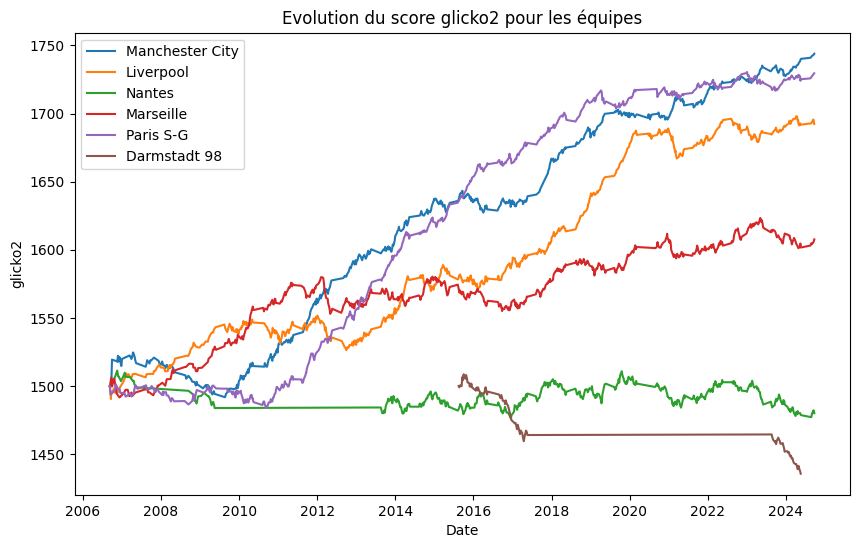

In [59]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'glicko2_home_before'
    metric_away = 'glicko2_away_before'
    metric = 'glicko2'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

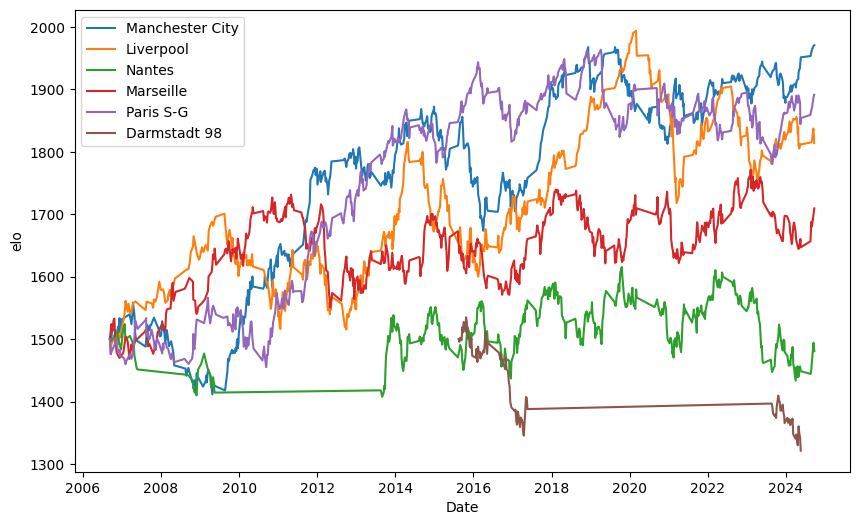

In [192]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'elo_home_before'
    metric_away = 'elo_away_before'
    metric = 'elo'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
#plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

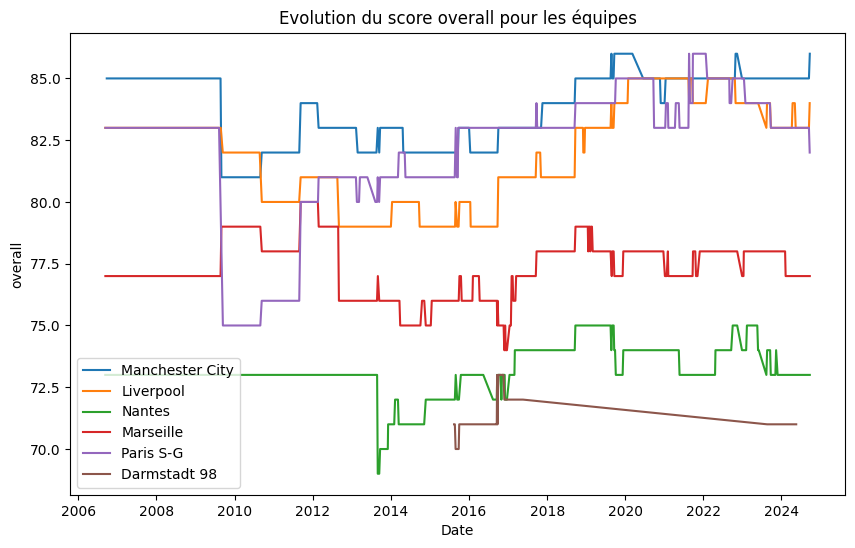

In [61]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'home_overall'
    metric_away = 'away_overall'
    metric = 'overall'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

In [ ]:
[
    'elo_home_before', 'elo_away_before',
    'home_team_number_of_match_played', 'away_team_number_of_match_played',
    'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
    'glicko2_rd_away_before', 'glicko2_vol_home_before',
    'glicko2_vol_away_before', 'trueskill_home_before',
    'trueskill_away_before']

['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

In [16]:
fbref_results_df__sofifa_merged__data_formated__signals_added__train[['home_chance_creation_shooting', 'home_defence_pressure']]

,home_chance_creation_shooting,home_defence_pressure
0,Little,Deep
5,Little,Deep
6,Little,Deep
12,Little,Deep
14,Little,Deep
...,...,...
32013,Little,Deep
32014,Little,Deep
32015,Little,Deep
32026,Little,Deep


In [15]:
fbref_results_df__sofifa_merged__data_formated__signals_added__train.columns

Index(['game_id', 'league', 'season', 'game', 'round', 'week', 'day', 'date',
       'time', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'index',
       'away_g', 'home_g', 'away_sat', 'home_sat', 'datetime_insert',
       'home_league', 'home_overall', 'home_attack', 'home_midfield',
       'home_defence', 'home_transfer_budget', 'home_club_worth',
       'home_build_up_speed', 'home_build_up_dribbling',
       'home_build_up_passing', 'home_build_up_positioning',
       'home_chance_creation_crossing', 'home_chance_creation_passing',
       'home_chance_creation_shooting', 'home_chance_creation_positioning',
       'home_defence_aggression', 'home_defence_pressure',
       'home_defence_team_width', 'home_defence_defender_line',
       'home_defence_domestic_prestige', 'home_international_prestige',
       'home_players', 'home_starting_xi_average_age',
       'home_whole_team_average_age', 'home_fifa_edit

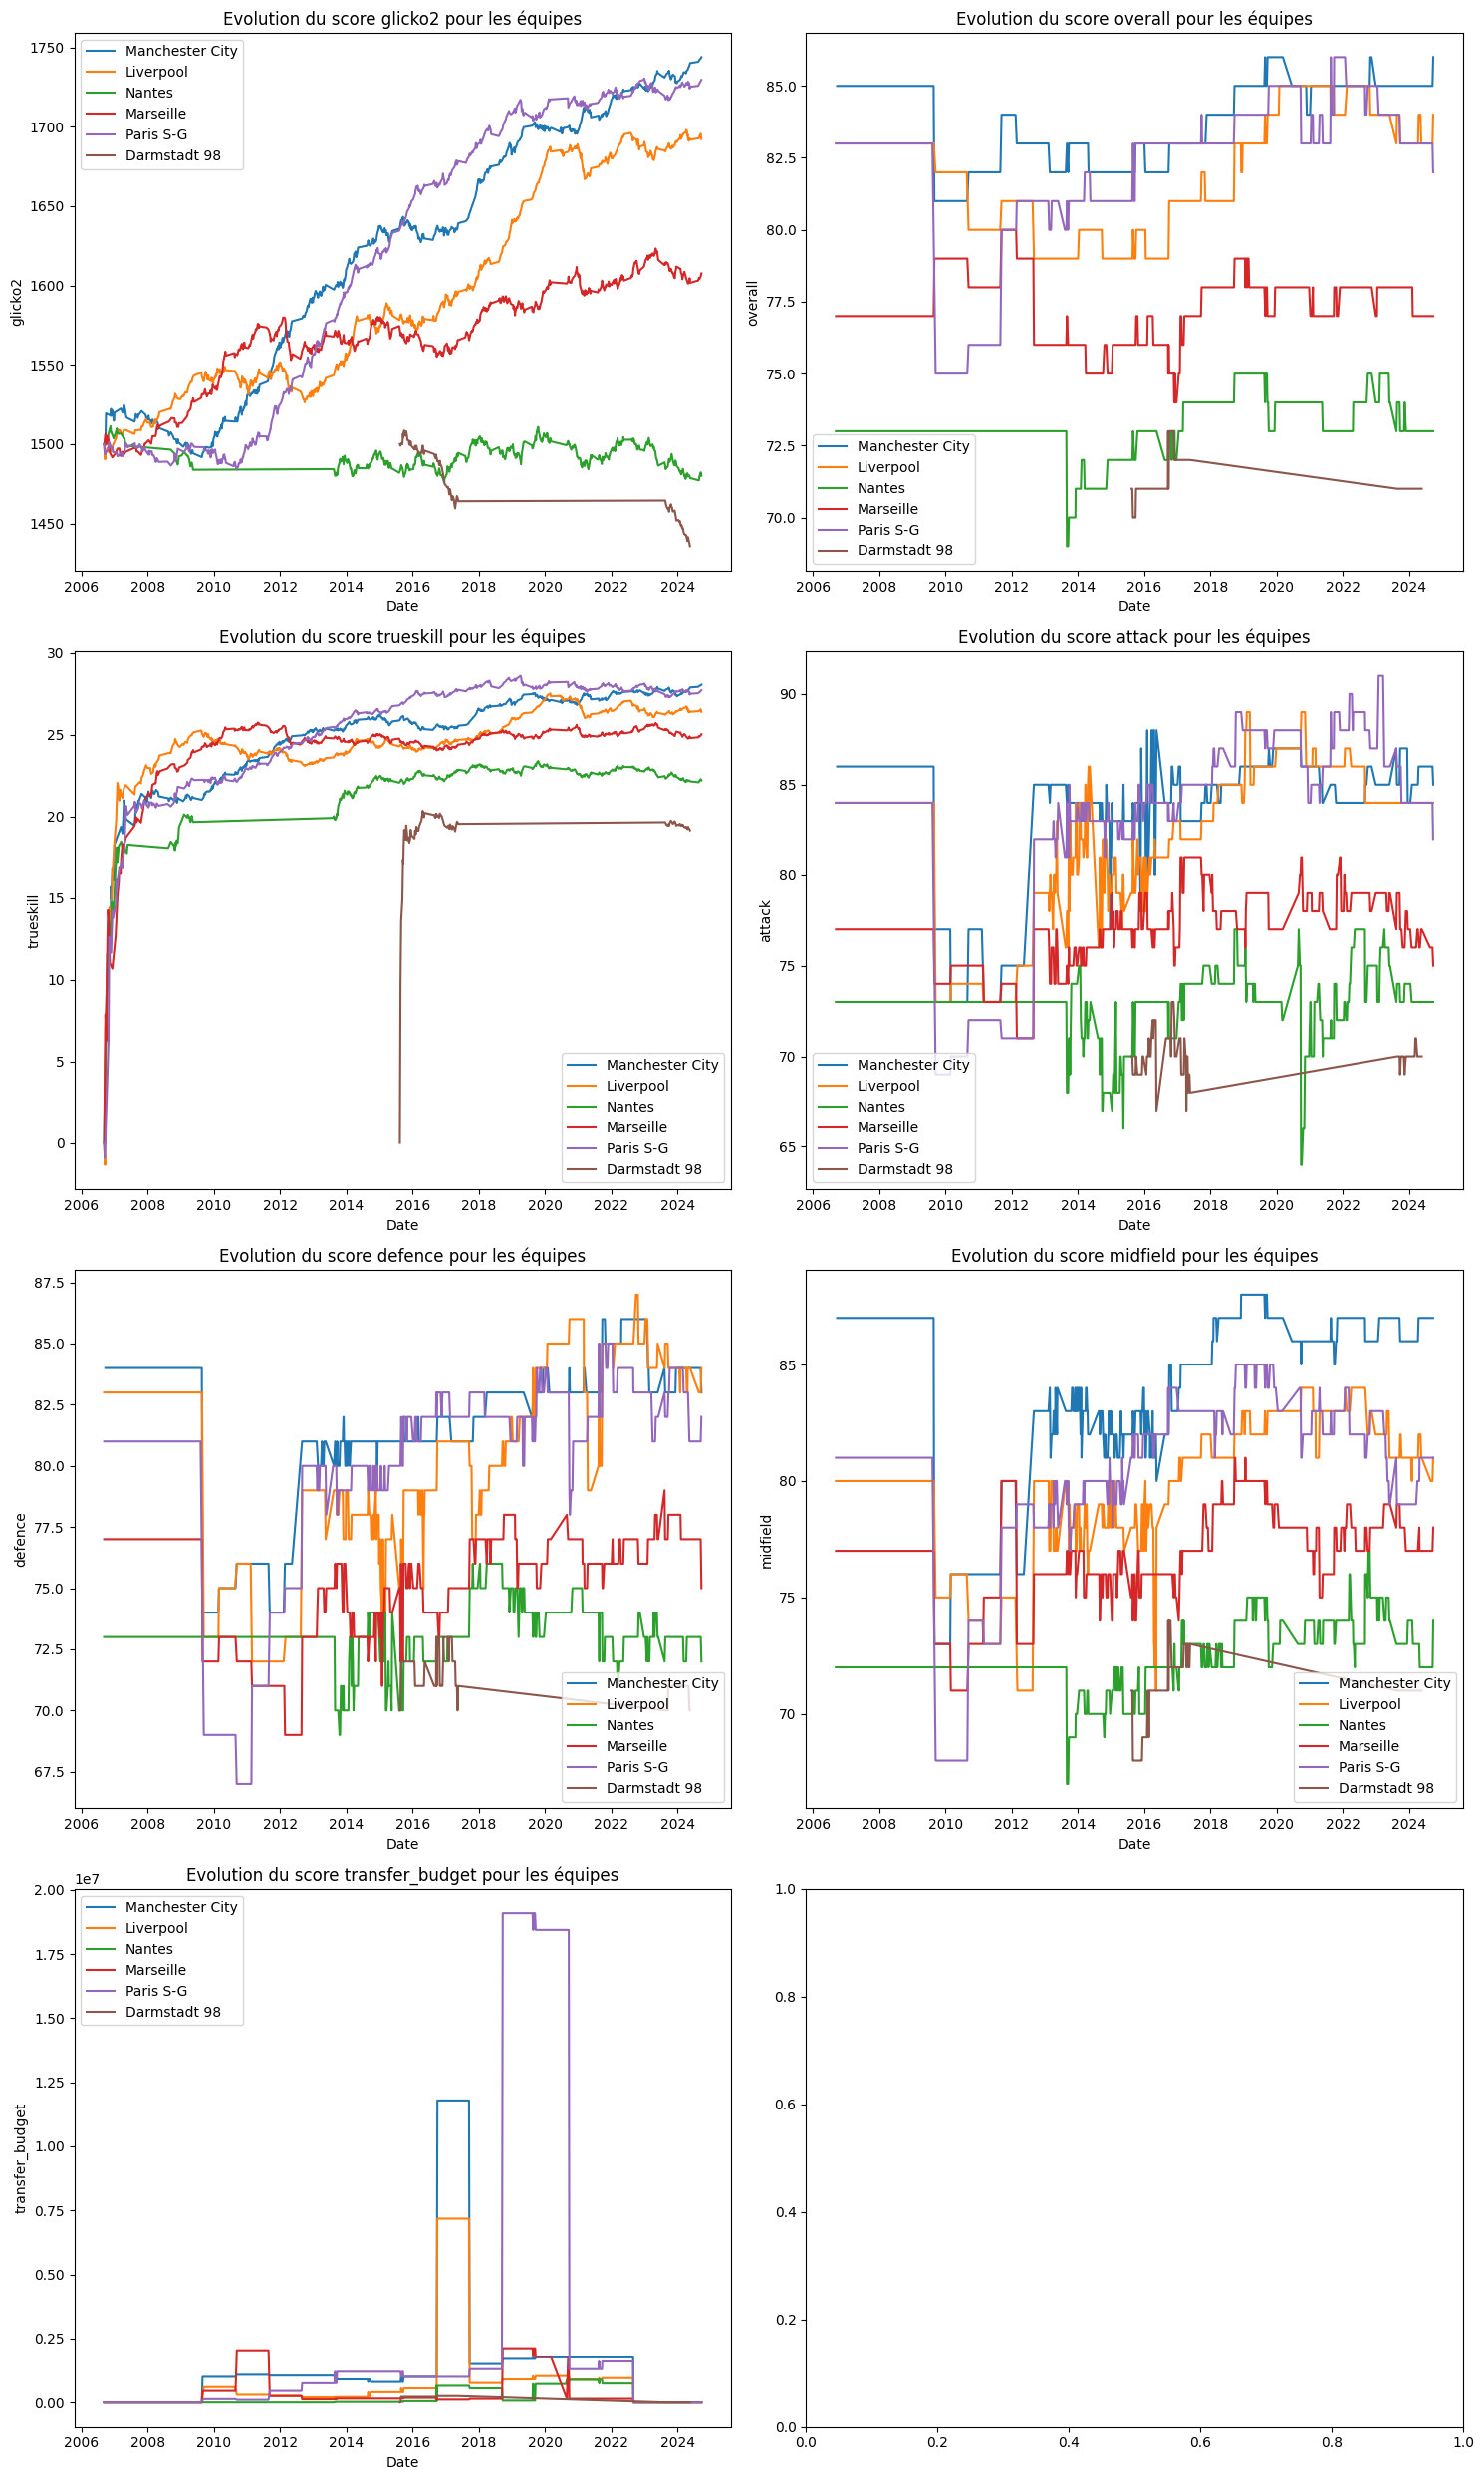

In [193]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
metrics = ['glicko2', 'overall', 'trueskill', "attack", "defence", "midfield", "transfer_budget"]
metrics_home = ['glicko2_home_before', 'home_overall', 'trueskill_home_before', "home_attack", "home_defence", "home_midfield", "home_transfer_budget"]
metrics_away = ['glicko2_away_before', 'away_overall', 'trueskill_away_before', "away_attack", "away_defence", "away_midfield", "away_transfer_budget"]
COL = 2
ROWS = math.ceil(metrics.__len__() / COL)

fig, ax = plt.subplots(ROWS, COL, figsize=(15, 15))

ax = ax.flatten()

for metric, metric_home, metric_away in zip(metrics, metrics_home, metrics_away):
    dfs = []
    for team_name in team_names:
        #team_name = 'Manchester City'
        metric_home = metric_home
        metric_away = metric_away
        #metric = 'overall'
        df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
        df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
        df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
        df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
        df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
        df_clicko_home["team"] = team_name
        df_clicko_away["team"] = team_name
        df_clicko = pd.concat([df_clicko_home, df_clicko_away])
        df_clicko = df_clicko.sort_values(by='date', ascending=True)
        df_clicko = df_clicko.reset_index(drop=True)
        dfs.append(df_clicko)
    for df in dfs:
        ax[metrics.index(metric)].plot(df['date'], df[metric], label=df['team'][0])
    ax[metrics.index(metric)].set_xlabel('Date')
    ax[metrics.index(metric)].set_ylabel(metric)
    ax[metrics.index(metric)].set_title(f'Evolution du score {metric} pour les équipes')
    ax[metrics.index(metric)].legend()

plt.tight_layout()
plt.show()



## Model selection

### Logistic regression baseline

In [103]:
feature_selection_results.head(40)

,Selected_Features,accuracy,weighted_accuracy,accuracy_home,accuracy_draw,accuracy_away,macro_avg_recall,micro_avg_recall,weighted_recall,recall_home,...,loss_draw,loss_away,mse,mse_home,mse_draw,mse_away,classwise_ECE,ECE_home,ECE_draw,ECE_away
0,elo_away_before,0.436429,0.594186,0.436429,0.735978,0.700451,0.333333,0.436429,0.436429,1.000000,...,0.358659,0.376227,0.216780,0.246242,0.194341,0.209757,0.017354,0.022240,0.011494,0.018327
1,elo_home_before,0.495221,0.646794,0.564292,0.735978,0.690171,0.423363,0.495221,0.495221,0.824908,...,0.359647,0.322852,0.206092,0.231599,0.194120,0.192558,0.023569,0.025898,0.012917,0.031893
2,glicko2_vol_away_before,0.515059,0.661971,0.586835,0.735978,0.707304,0.444233,0.515059,0.515059,0.838398,...,0.363159,0.324290,0.196527,0.215104,0.192303,0.182174,0.027861,0.034308,0.019042,0.030235
3,away_overall,0.514698,0.662900,0.595672,0.735798,0.697926,0.446853,0.514698,0.514698,0.816750,...,0.355246,0.316269,0.196141,0.214399,0.192201,0.181822,0.024428,0.025859,0.019160,0.028266
4,home_overall,0.520108,0.666644,0.599639,0.736159,0.704418,0.451855,0.520108,0.520108,0.824074,...,0.355224,0.317717,0.195897,0.214173,0.192208,0.181310,0.028565,0.032835,0.023316,0.029544
5,away_build_up_speed_Slow,0.522633,0.667767,0.596573,0.735798,0.712894,0.452342,0.522633,0.522633,0.838654,...,0.356727,0.322046,0.195326,0.213231,0.192053,0.180694,0.026003,0.028270,0.021360,0.028380
6,away_starting_xi_average_age,0.523174,0.668619,0.602164,0.735618,0.708566,0.453562,0.523174,0.523174,0.829986,...,0.355600,0.315863,0.195112,0.212853,0.192018,0.180464,0.024999,0.025523,0.020898,0.028576
7,home_league_INT,0.523354,0.668985,0.604509,0.735798,0.706402,0.454227,0.523354,0.523354,0.827919,...,0.355522,0.314943,0.194952,0.212847,0.191906,0.180103,0.025350,0.027782,0.023165,0.025102
8,avg_home_team_goals_season_to_date_before_match,0.524076,0.669744,0.607574,0.735618,0.704959,0.455648,0.524076,0.524076,0.821189,...,0.355990,0.311096,0.194812,0.212581,0.191898,0.179957,0.024879,0.024795,0.023652,0.026191
9,home_build_up_positioning_Organised,0.523715,0.669637,0.608476,0.735437,0.703517,0.455485,0.523715,0.523715,0.819517,...,0.355543,0.310804,0.194698,0.212347,0.191729,0.180019,0.024142,0.023524,0.022783,0.026120


In [102]:
list(feature_selection_results['mse']).index(np.min(list(feature_selection_results['mse'])))

34

In [107]:
feature_selection_results['mse'].head(36)

0     0.216780
1     0.206092
2     0.196527
3     0.196141
4     0.195897
5     0.195326
6     0.195112
7     0.194952
8     0.194812
9     0.194698
10    0.194636
11    0.194575
12    0.194533
13    0.194525
14    0.194490
15    0.194466
16    0.194442
17    0.194422
18    0.194402
19    0.194384
20    0.194366
21    0.194356
22    0.194340
23    0.194319
24    0.194309
25    0.194356
26    0.194345
27    0.194343
28    0.194341
29    0.194342
30    0.194339
31    0.194337
32    0.194313
33    0.194306
34    0.194301
35    0.194304
Name: mse, dtype: float64

In [118]:
# accuracy
from sklearn.metrics import accuracy_score
feat_selected = list(feature_selection_results['Selected_Features'][:35])
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

df_train = df_all[df_all['datetime'] < datetime.datetime(2021, 1, 1)][feat_selected[:36]]
df_train_res = df_all[df_all['datetime'] < datetime.datetime(2021, 1, 1)][Y_col]
df_test = df_all[df_all['datetime'] >= datetime.datetime(2021, 1, 1)][feat_selected[:36]]
df_test_res = df_all[df_all['datetime'] >= datetime.datetime(2021, 1, 1)][Y_col]

pipeline.fit(df_train, df_train_res)
y_pred = pipeline.predict(df_test)
accuracy_score(df_test_res, y_pred)


0.530240142306552

In [117]:
feat_selected

['elo_away_before',
 'elo_home_before',
 'glicko2_vol_away_before',
 'away_overall',
 'home_overall',
 'away_build_up_speed_Slow',
 'away_starting_xi_average_age',
 'home_league_INT',
 'avg_home_team_goals_season_to_date_before_match',
 'home_build_up_positioning_Organised',
 'home_build_up_speed_Fast',
 'away_defence_pressure_High',
 'away_defence_defender_line_Offside trap',
 'home_league_ITA-Serie A',
 'glicko2_rd_home_before',
 'home_chance_creation_shooting_Normal',
 'away_build_up_passing_Mixed',
 'away_team_goals_season_to_date_before_match',
 'home_chance_creation_passing_Risky',
 'away_chance_creation_positioning_Organised',
 'away_defence_pressure_Medium',
 'away_defence_domestic_prestige',
 'away_chance_creation_shooting_Lots',
 'home_defence_defender_line_Offside trap',
 'away_defence_team_width_Wide',
 'home_defence_pressure_Medium',
 'home_build_up_speed_Slow',
 'away_defence_aggression_Press',
 'trueskill_home_before',
 'away_build_up_positioning_Organised',
 'away_defen

In [119]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

X_col_selected = list(feature_selection_results['Selected_Features'][:35])
metrics_mean, metrics, _ = train_test(df_all, pipeline, X_col, Y_col, train_test_split_fn_slid, result_df_all_splits, m, beta)
train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
train_test_metrics

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,metrics,values
0,accuracy,0.519206
1,weighted_accuracy,0.667058
2,accuracy_home,0.608296
3,accuracy_draw,0.725699
4,accuracy_away,0.704418
5,macro_avg_recall,0.452496
6,micro_avg_recall,0.519206
7,weighted_recall,0.519206
8,recall_home,0.810343
9,recall_draw,0.030505


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier

models = [LogisticRegression(), RandomForestClassifier(), MLPClassifier(), KNeighborsClassifier(), GradientBoostingClassifier(), 
          AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GaussianNB(), DecisionTreeClassifier(), 
          ExtraTreeClassifier(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
         LogisticRegressionCV()]

metrcis_per_model = []
for model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    metrics_mean, metrics, _ = train_test(df_all, pipeline, X_col_selected, Y_col, train_test_split_fn_slid, result_df_all_splits, m, beta)
    train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
    metrcis_per_model.append(train_test_metrics)
    print(f'{model} : accuracy={metrics_mean["accuracy"]}, mse={metrics_mean["mse"]}, log_loss={metrics_mean["log_loss"]}')
df_models_comp = pd.DataFrame({'metrics': metrcis_per_model[0]['metrics'], **{model.__str__() : metrcis_per_model[i]['values'] for i, model in enumerate(models)}})
df_models_comp

LogisticRegression() : accuracy=0.5197475202885482, mse=0.19533714599425364, log_loss=0.9833681161267596
RandomForestClassifier() : accuracy=0.4964833183047791, mse=0.20225998196573464, log_loss=1.02245084993644


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

MLPClassifier() : accuracy=0.466726780883679, mse=0.22422830963379076, log_loss=1.1865280203570312
KNeighborsClassifier() : accuracy=0.436068530207394, mse=0.23771565975353134, log_loss=5.403523644797889
GradientBoostingClassifier() : accuracy=0.5094679891794409, mse=0.1994323301240155, log_loss=1.001681453488032


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

AdaBoostClassifier() : accuracy=0.5073038773669973, mse=0.22063103450546126, log_loss=1.091515711525678
BaggingClassifier() : accuracy=0.45500450856627583, mse=0.22397715659753534, log_loss=2.4711669769069813
ExtraTreesClassifier() : accuracy=0.4833183047790802, mse=0.20426130447850904, log_loss=1.0260968927062986
GaussianNB() : accuracy=0.41190261496844005, mse=0.33225176118382144, log_loss=7.5701673459641246
DecisionTreeClassifier() : accuracy=0.4146077547339946, mse=0.3902614968440036, log_loss=20.21873186255738
ExtraTreeClassifier() : accuracy=0.40108205590622187, mse=0.39927862939585207, log_loss=20.685892949954734
LinearDiscriminantAnalysis() : accuracy=0.5211902614968441, mse=0.19522890636271548, log_loss=0.9824511181176812


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis() : accuracy=0.37799819657348965, mse=0.3525647103003505, log_loss=10.830730981060343
LogisticRegressionCV() : accuracy=0.5197475202885482, mse=0.195512703847382, log_loss=0.9834270986078956


[                metrics    values
 0              accuracy  0.519748
 1     weighted_accuracy  0.666899
 2         accuracy_home  0.604689
 3         accuracy_draw  0.732913
 4         accuracy_away  0.701894
 5      macro_avg_recall  0.452244
 6      micro_avg_recall  0.519748
 7       weighted_recall  0.519748
 8           recall_home  0.815347
 9           recall_draw  0.011333
 10          recall_away  0.530050
 11  macro_avg_precision  0.448712
 12  micro_avg_precision  0.519748
 13   weighted_precision  0.467207
 14       precision_home  0.530788
 15       precision_draw  0.317857
 16       precision_away  0.497491
 17   macro_avg_f_mesure  0.392263
 18   micro_avg_f_mesure  0.702459
 19    weighted_f_mesure  0.441262
 20        f_mesure_home  0.642766
 21        f_mesure_draw  0.021661
 22        f_mesure_away  0.512362
 23             log_loss  0.983368
 24            loss_home  0.311067
 25            loss_draw  0.360025
 26            loss_away  0.312276
 27                 

In [139]:
df_models_comp = pd.DataFrame({'metrics': metrcis_per_model[0]['metrics'], **{model.__str__() : metrcis_per_model[i]['values'] for i, model in enumerate(models)}})
df_models_comp

,metrics,LogisticRegression(),RandomForestClassifier(),MLPClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),BaggingClassifier(),ExtraTreesClassifier(),GaussianNB(),DecisionTreeClassifier(),ExtraTreeClassifier(),LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),LogisticRegressionCV()
0,accuracy,0.519748,0.496483,0.466727,0.436069,0.509468,0.507304,0.455005,0.483318,0.411903,0.414608,0.401082,0.521190,0.377998,0.519748
1,weighted_accuracy,0.666899,0.652378,0.634608,0.619149,0.661193,0.658691,0.630882,0.645953,0.610054,0.604472,0.594109,0.667993,0.585603,0.666198
2,accuracy_home,0.604689,0.594770,0.584851,0.598738,0.603607,0.598738,0.602344,0.597475,0.615329,0.577818,0.559243,0.606492,0.581605,0.601623
3,accuracy_draw,0.732913,0.704779,0.664923,0.642741,0.709288,0.721371,0.646168,0.682777,0.583950,0.613886,0.614608,0.731650,0.561046,0.734896
4,accuracy_away,0.701894,0.693417,0.683679,0.630658,0.706041,0.694500,0.661497,0.686384,0.624527,0.637511,0.628314,0.704238,0.613345,0.702976
5,macro_avg_recall,0.452244,0.439212,0.423954,0.414272,0.444922,0.441468,0.424592,0.427529,0.412072,0.394308,0.379753,0.454540,0.381597,0.449011
6,micro_avg_recall,0.519748,0.496483,0.466727,0.436069,0.509468,0.507304,0.455005,0.483318,0.411903,0.414608,0.401082,0.521190,0.377998,0.519748
7,weighted_recall,0.519748,0.496483,0.466727,0.436069,0.509468,0.507304,0.455005,0.483318,0.411903,0.414608,0.401082,0.521190,0.377998,0.519748
8,recall_home,0.815347,0.745922,0.656506,0.510965,0.791569,0.793683,0.581708,0.729859,0.408987,0.509140,0.494881,0.814474,0.358551,0.830203
9,recall_draw,0.011333,0.087906,0.192524,0.218624,0.056198,0.039977,0.211403,0.098995,0.379615,0.297119,0.280638,0.025853,0.387401,0.002653


In [142]:
df_models_comp_t = df_models_comp.set_index('metrics').T
df_models_comp_t

metrics,accuracy,weighted_accuracy,accuracy_home,accuracy_draw,accuracy_away,macro_avg_recall,micro_avg_recall,weighted_recall,recall_home,recall_draw,...,loss_draw,loss_away,mse,mse_home,mse_draw,mse_away,classwise_ECE,ECE_home,ECE_draw,ECE_away
LogisticRegression(),0.519748,0.666899,0.604689,0.732913,0.701894,0.452244,0.519748,0.519748,0.815347,0.011333,...,0.360025,0.312276,0.195337,0.213138,0.191955,0.180919,0.029304,0.034766,0.029732,0.023414
RandomForestClassifier(),0.496483,0.652378,0.594770,0.704779,0.693417,0.439212,0.496483,0.496483,0.745922,0.087906,...,0.364207,0.329790,0.202260,0.221526,0.197632,0.187623,0.038269,0.037394,0.049367,0.028045
MLPClassifier(),0.466727,0.634608,0.584851,0.664923,0.683679,0.423954,0.466727,0.466727,0.656506,0.192524,...,0.422211,0.393571,0.224228,0.248180,0.221111,0.203393,0.107504,0.115832,0.120258,0.086424
KNeighborsClassifier(),0.436069,0.619149,0.598738,0.642741,0.630658,0.414272,0.436069,0.436069,0.510965,0.218624,...,2.380246,1.755071,0.237716,0.261814,0.230716,0.220617,0.096014,0.113977,0.097133,0.076934
GradientBoostingClassifier(),0.509468,0.661193,0.603607,0.709288,0.706041,0.444922,0.509468,0.509468,0.791569,0.056198,...,0.366332,0.321157,0.199432,0.216789,0.197000,0.184508,0.037320,0.032792,0.048249,0.030918
AdaBoostClassifier(),0.507304,0.658691,0.598738,0.721371,0.694500,0.441468,0.507304,0.507304,0.793683,0.039977,...,0.291501,0.327989,0.220631,0.253610,0.199239,0.209044,0.069168,0.101164,0.069286,0.037054
BaggingClassifier(),0.455005,0.630882,0.602344,0.646168,0.661497,0.424592,0.455005,0.455005,0.581708,0.211403,...,1.002731,0.888686,0.223977,0.245867,0.219028,0.207037,0.092744,0.099459,0.111362,0.067412
ExtraTreesClassifier(),0.483318,0.645953,0.597475,0.682777,0.686384,0.427529,0.483318,0.483318,0.729859,0.098995,...,0.368169,0.324233,0.204261,0.222435,0.200157,0.190192,0.043213,0.042344,0.058370,0.028923
GaussianNB(),0.411903,0.610054,0.615329,0.583950,0.624527,0.412072,0.411903,0.411903,0.408987,0.379615,...,1.044105,2.635749,0.332252,0.323353,0.336283,0.337119,0.302075,0.284141,0.303527,0.318556
DecisionTreeClassifier(),0.414608,0.604472,0.577818,0.613886,0.637511,0.394308,0.414608,0.414608,0.509140,0.297119,...,6.403221,6.428137,0.390261,0.422182,0.386114,0.362489,0.195131,0.208296,0.200721,0.176375


In [166]:
df_sorted = df_models_comp_t.sort_values(by='mse', ascending=True)
df_sorted.tail(13)[['mse', 'log_loss', 'classwise_ECE', 'accuracy_home', 'accuracy_draw', 'accuracy_away']]

metrics,mse,log_loss,classwise_ECE,accuracy_home,accuracy_draw,accuracy_away
LogisticRegression(),0.195337,0.983368,0.029304,0.604689,0.732913,0.701894
LogisticRegressionCV(),0.195513,0.983427,0.028105,0.601623,0.734896,0.702976
GradientBoostingClassifier(),0.199432,1.001681,0.037320,0.603607,0.709288,0.706041
RandomForestClassifier(),0.202260,1.022451,0.038269,0.594770,0.704779,0.693417
ExtraTreesClassifier(),0.204261,1.026097,0.043213,0.597475,0.682777,0.686384
AdaBoostClassifier(),0.220631,1.091516,0.069168,0.598738,0.721371,0.694500
BaggingClassifier(),0.223977,2.471167,0.092744,0.602344,0.646168,0.661497
MLPClassifier(),0.224228,1.186528,0.107504,0.584851,0.664923,0.683679
KNeighborsClassifier(),0.237716,5.403524,0.096014,0.598738,0.642741,0.630658
GaussianNB(),0.332252,7.570167,0.302075,0.615329,0.583950,0.624527


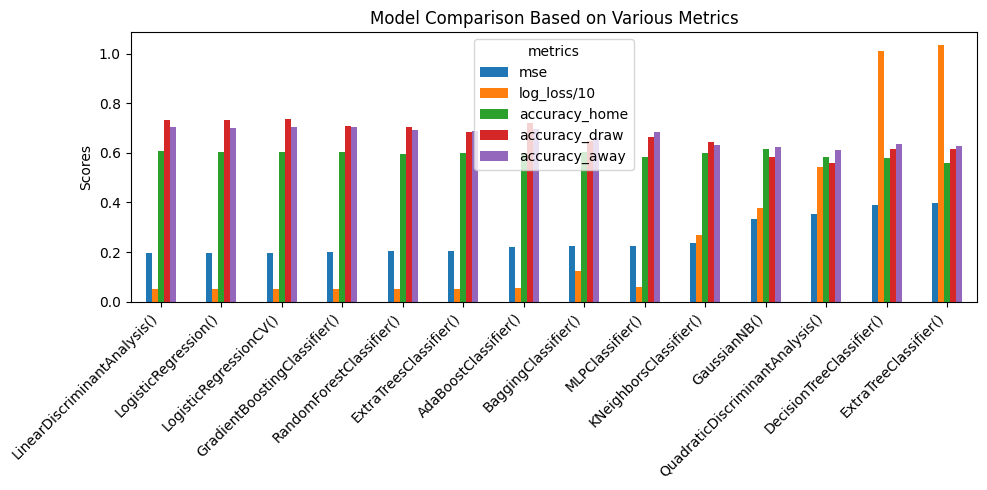

In [158]:
df_models_comp_t['log_loss/10'] = df_models_comp_t['log_loss'] / 20
df_sorted = df_models_comp_t.sort_values(by='mse', ascending=True)

# Plotting the bar plot for each metric
metrics = ['mse', 'log_loss/10', 'accuracy_home', 'accuracy_draw', 'accuracy_away']

# Creating a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
df_sorted[metrics].plot(kind='bar', ax=ax)

plt.title('Model Comparison Based on Various Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

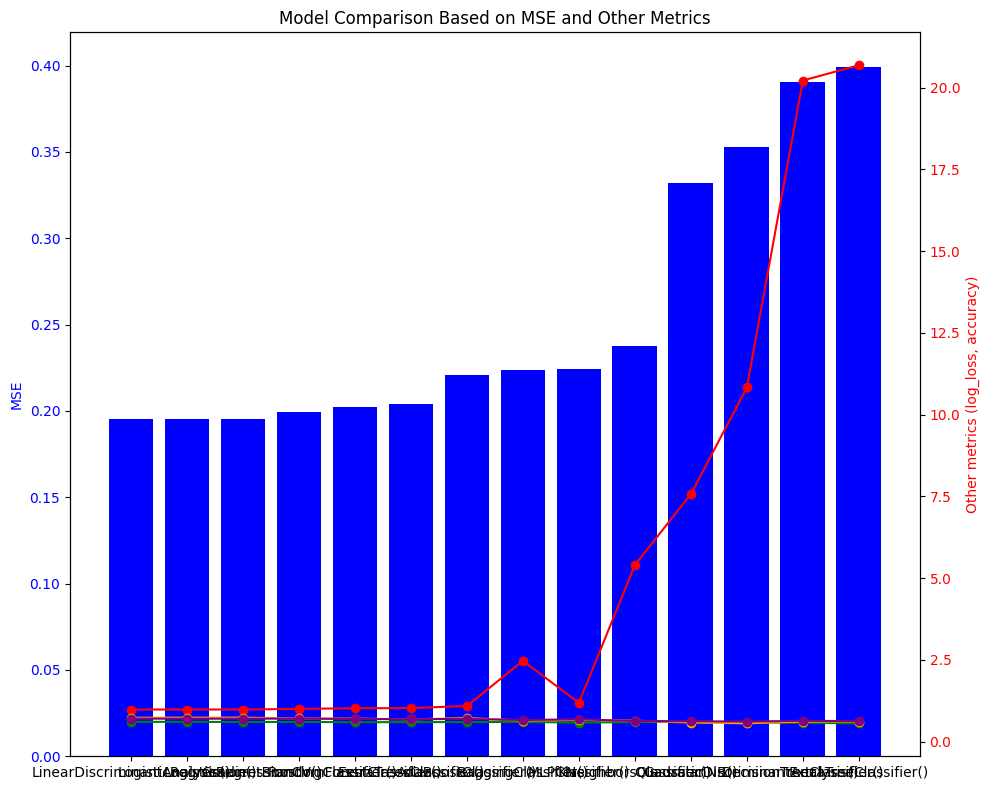

In [151]:
# Sorting the DataFrame by 'mse' in ascending order
df_sorted = df_models_comp_t.sort_values(by='mse', ascending=True)

# Creating the bar plot with different scales for each metric
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plotting 'mse' on the left y-axis
ax1.bar(df_sorted.index, df_sorted['mse'], color='b', label='mse')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a second y-axis for the other metrics
ax2 = ax1.twinx()
ax2.plot(df_sorted.index, df_sorted['log_loss'], color='r', marker='o', label='log_loss')
ax2.plot(df_sorted.index, df_sorted['accuracy_home'], color='g', marker='o', label='accuracy_home')
ax2.plot(df_sorted.index, df_sorted['accuracy_draw'], color='orange', marker='o', label='accuracy_draw')
ax2.plot(df_sorted.index, df_sorted['accuracy_away'], color='purple', marker='o', label='accuracy_away')
ax2.set_ylabel('Other metrics (log_loss, accuracy)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding titles and formatting
plt.title('Model Comparison Based on MSE and Other Metrics')
fig.tight_layout()

plt.show()


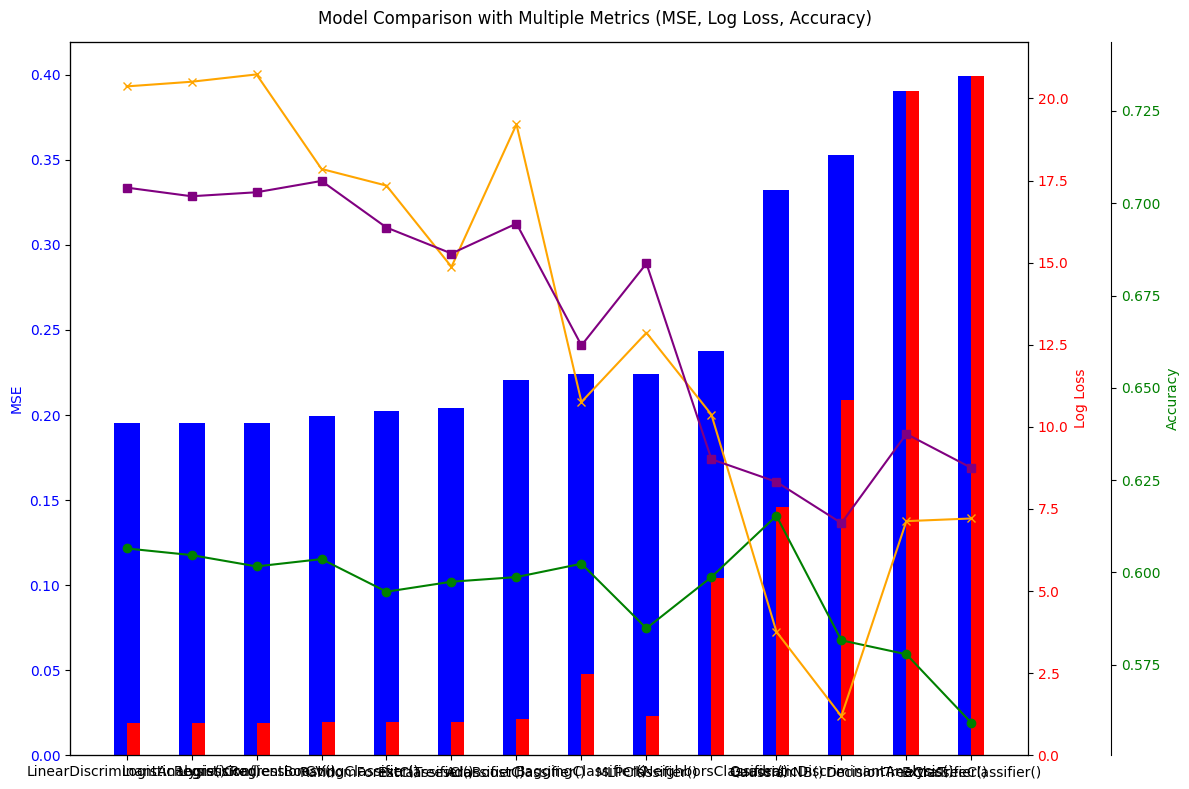

In [152]:
# Creating a bar plot with multiple scales (grouped bars by models with different scales for metrics)
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting 'mse' as bars on the primary y-axis (left)
ax1.bar(df_sorted.index, df_sorted['mse'], color='b', width=0.4, align='center', label='MSE')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for 'log_loss'
ax2 = ax1.twinx()
ax2.bar(df_sorted.index, df_sorted['log_loss'], color='r', width=0.2, align='edge', label='Log Loss')
ax2.set_ylabel('Log Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Creating a third y-axis for 'accuracy' (combining accuracy_home, accuracy_draw, accuracy_away)
ax3 = ax1.twinx()
ax3.spines.right.set_position(("outward", 60))  # To avoid overlap
ax3.plot(df_sorted.index, df_sorted['accuracy_home'], color='g', marker='o', label='Accuracy Home')
ax3.plot(df_sorted.index, df_sorted['accuracy_draw'], color='orange', marker='x', label='Accuracy Draw')
ax3.plot(df_sorted.index, df_sorted['accuracy_away'], color='purple', marker='s', label='Accuracy Away')
ax3.set_ylabel('Accuracy', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Adding titles and legends
fig.suptitle('Model Comparison with Multiple Metrics (MSE, Log Loss, Accuracy)')
fig.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()


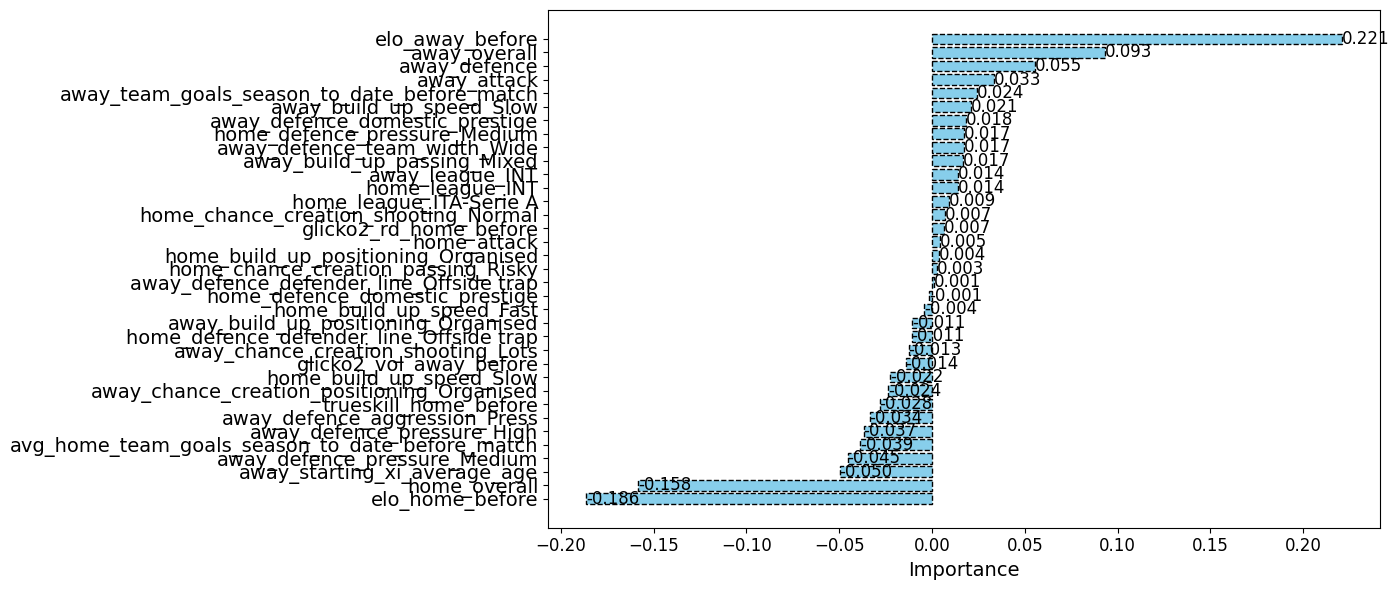

In [182]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

pipeline.fit(df_all[X_col_selected], df_all[Y_col])

# Récupérer le modèle (LogisticRegression) à partir du pipeline
model = pipeline.named_steps['model']

# Récupérer les coefficients de la régression logistique
coefficients = model.coef_[0]  # Coefficients pour chaque feature

# Associer les coefficients avec les noms des features
feature_importance = pd.DataFrame({
    'Feature': X_col_selected,
    'Importance': coefficients
})

# Trier par importance absolue
feature_importance['Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
feature_importance.head(20)


# Sort values by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue', edgecolor='black', linestyle='--')
plt.xlabel('Importance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # To display the most important feature at the top

# Adding value labels at the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', va='center', fontsize=12)

plt.tight_layout()

# Show plot
plt.show()
plt.show()

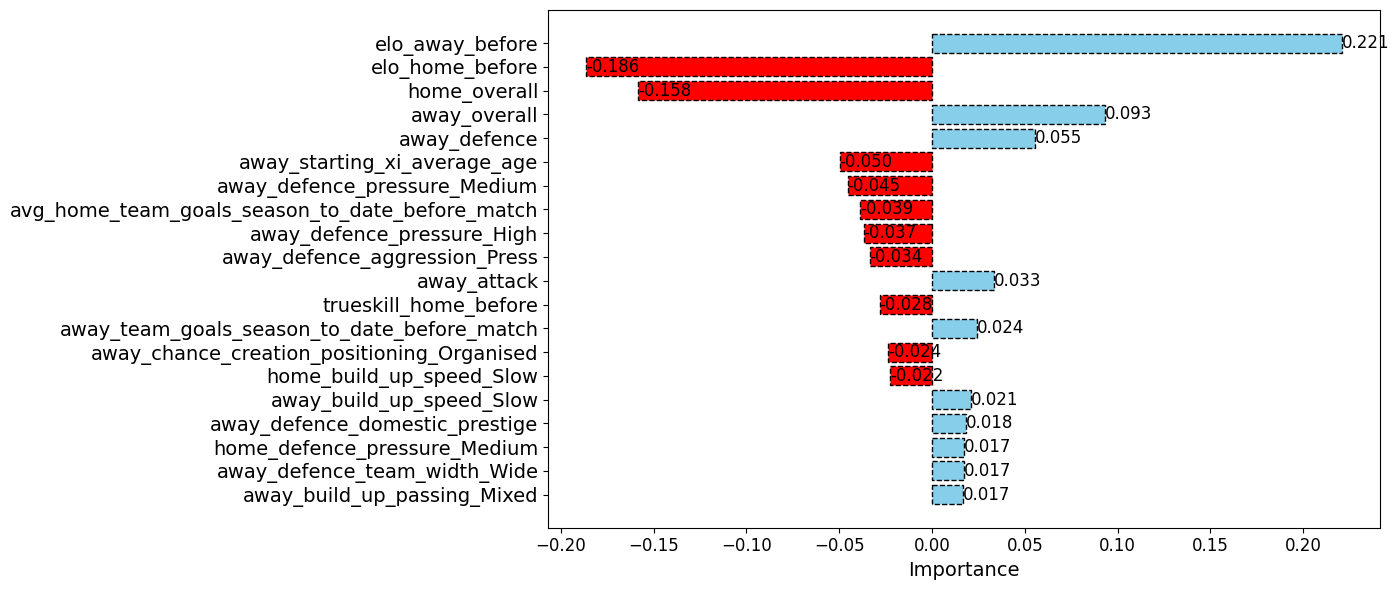

In [183]:

# Creating the DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_col_selected,
    'Importance': coefficients
})

# Sort values by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))

# Highlight negative coefficients in red and positive in blue
colors = ['red' if coef < 0 else 'skyblue' for coef in feature_importance['Importance']]
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='black', linestyle='--')

plt.xlabel('Importance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # To display the most important feature at the top

# Adding value labels at the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', va='center', fontsize=12)

plt.tight_layout()

# Show plot
plt.show()

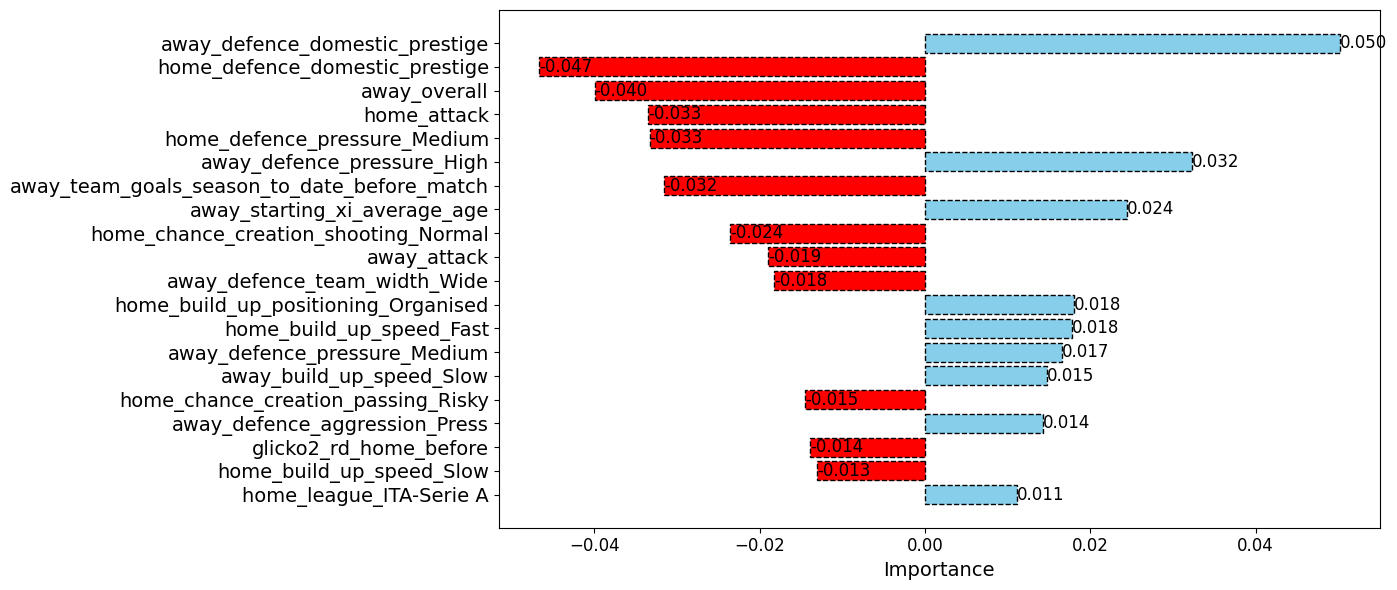

In [185]:
coefficients = model.coef_[1] 
# Creating the DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_col_selected,
    'Importance': coefficients
})

# Sort values by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))

# Highlight negative coefficients in red and positive in blue
colors = ['red' if coef < 0 else 'skyblue' for coef in feature_importance['Importance']]
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='black', linestyle='--')

plt.xlabel('Importance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # To display the most important feature at the top

# Adding value labels at the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', va='center', fontsize=12)

plt.tight_layout()

# Show plot
plt.show()

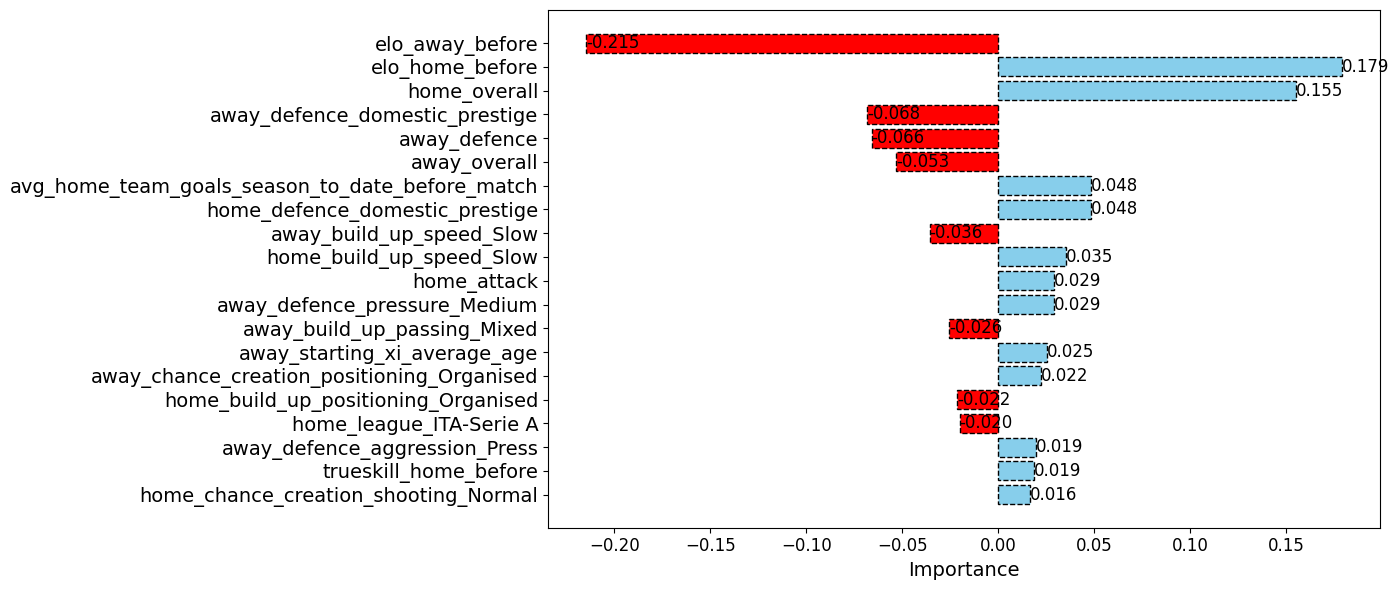

In [186]:
coefficients = model.coef_[2] 
# Creating the DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_col_selected,
    'Importance': coefficients
})

# Sort values by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(14, 6))

# Highlight negative coefficients in red and positive in blue
colors = ['red' if coef < 0 else 'skyblue' for coef in feature_importance['Importance']]
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='black', linestyle='--')

plt.xlabel('Importance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # To display the most important feature at the top

# Adding value labels at the end of the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.3f}', va='center', fontsize=12)

plt.tight_layout()

# Show plot
plt.show()